In [1]:
import cv2 as cv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.rc('image', cmap='gray')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

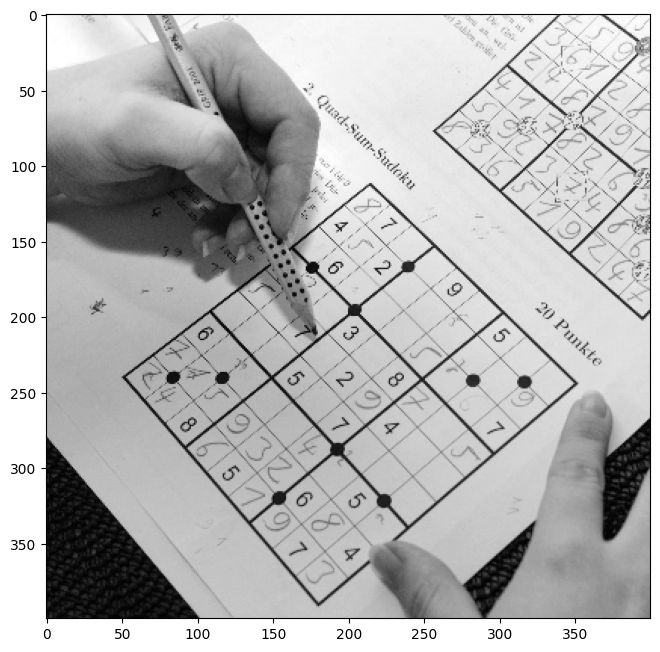

In [2]:
Org=cv.imread("Samples/9.jpg")
Org_Color=cv.resize(Org,(400,round(Org.shape[0]/Org.shape[1]*400)))
Org=cv.cvtColor(Org_Color,cv.COLOR_RGB2GRAY)
Org=Org-np.min(Org)
plt.imshow(Org)

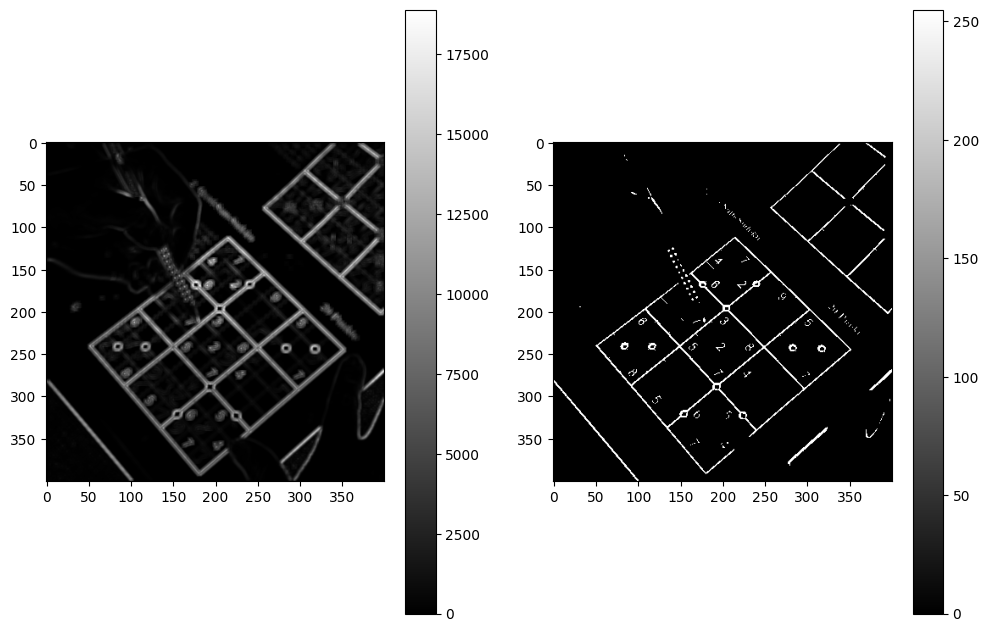

In [3]:
def variance_filter(I, n=7):
    I=np.array(I,dtype=np.float)
    h,w=I.shape
    result=np.zeros(I.shape)
    
    
    result=cv.GaussianBlur(I,(n,n),1,1)
    
    for y in range(h):
        for x in range(w):
            
            sum=0
            for i in range(-n//2,n//2+1):
                for j in range(-n//2,n//2+1):
                    
                    xi,yi=x+i,y+j   
                    sum+=(I[yi,xi]-result[y,x])*(I[yi,xi]-result[y,x])\
                          if xi>0 and yi>0 and yi<h and xi<w else 0
            
            result[y,x]=sum/(n**2-1)           
    return result        


I=np.copy(Org)
I_var=variance_filter(I,5)
I=cv.bitwise_not(I)*I_var
I=I/np.max(I)*255
I=np.array(I,dtype=np.uint8)
#I=cv.GaussianBlur(I,(3,3),1)
#I= cv.adaptiveThreshold(I,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY_INV,11,2)
I = cv.threshold(I,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)[1]
#I=cv.Canny(I,50,150,apertureSize = 3)

plt.subplot(121)
plt.imshow(I_var)
plt.colorbar()
plt.subplot(122)
plt.imshow(I)
plt.colorbar()

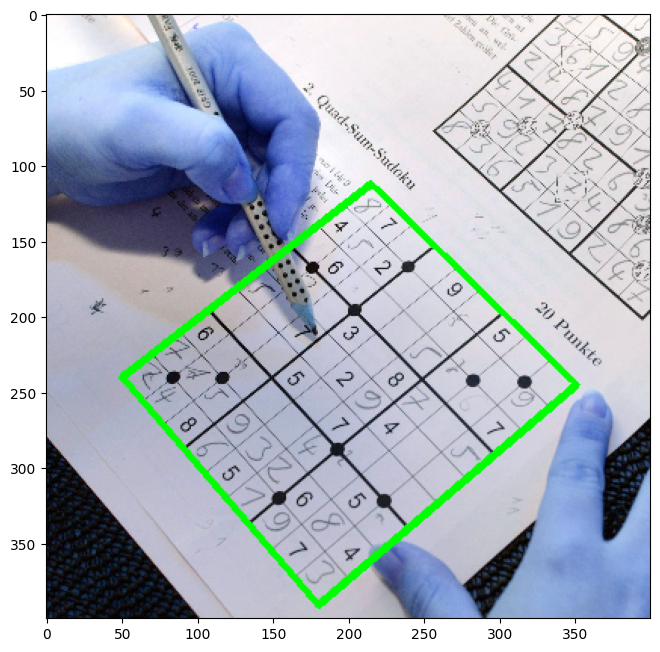

In [4]:
I_Contour=np.copy(Org_Color)
contours, hierarchy = cv.findContours(I,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Find the index of the largest contour
areas = [cv.contourArea(c) for c in contours]
max_index = np.argmax(areas)
cnt=contours[max_index]
epsilon = 0.1*cv.arcLength(cnt,True)
approx = cv.approxPolyDP(cnt,epsilon,True)
#approx=cnt
cv.drawContours(I_Contour, [approx], -1, (0, 255, 0), 3)



plt.imshow(I_Contour)

[[215. 112.]
 [ 50. 240.]
 [351. 245.]
 [180. 391.]]


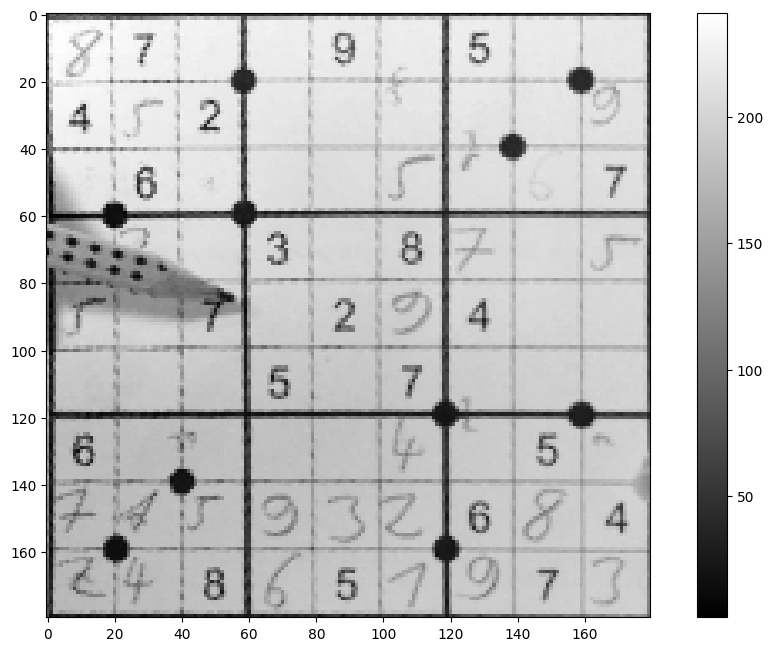

In [5]:
ROI=np.copy(Org)
#pts_dst = np.float32([[15,15],[15,165],[165, 15],[165, 165]])
pts_dst = np.float32([[0,0],[0,180],[180, 0],[180, 180]])
pts_src=approx.flatten()
pts_src=np.float32([[pts_src[0],pts_src[1]],[pts_src[2],pts_src[3]],[pts_src[6], pts_src[7]],[pts_src[4], pts_src[5]]])
print(pts_src)
trans = cv.getPerspectiveTransform(pts_src, pts_dst)
#ROI = cv.warpPerspective(ROI, trans, (180,180))
ROI = cv.warpPerspective(ROI, trans, (180,180))
plt.imshow(ROI)
plt.colorbar()

39


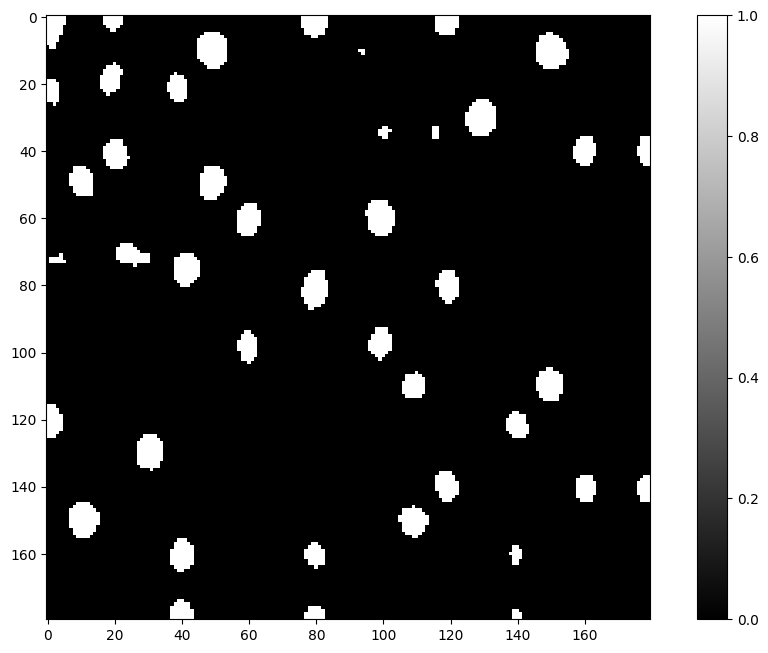

In [6]:
h,w=ROI.shape
possible_digits=[]
ROI=ROI-np.min(ROI)
digits=ROI\
        -cv.dilate(ROI,cv.getStructuringElement(cv.MORPH_RECT,(11,1)))\
        -cv.dilate(ROI,cv.getStructuringElement(cv.MORPH_RECT,(1,11)))

kernel=np.zeros((20,20))
kernel[2:17,4:15]=cv.getStructuringElement(cv.MORPH_ELLIPSE,(11,15))
kernel*=np.dot(cv.getGaussianKernel(20,4),cv.getGaussianKernel(20,3).T)
kernel/=np.sum(kernel)

kernel2=np.dot(cv.getGaussianKernel(20,5),cv.getGaussianKernel(20,4).T)
kernel2[2:17,4:15]=0
kernel2/=np.sum(kernel2)
kernel2-=np.ones((20,20))
kernel2/=np.sum(abs(kernel2))
kernel=kernel+kernel2
img=cv.filter2D(digits,ddepth=cv.CV_32F,kernel=kernel,anchor=(0,0))
max=cv.dilate(img,np.ones((20,20)))

max=img==max
thr=img>15
max=thr*max

plt.imshow(thr)
plt.colorbar()
print(np.sum(max))

            

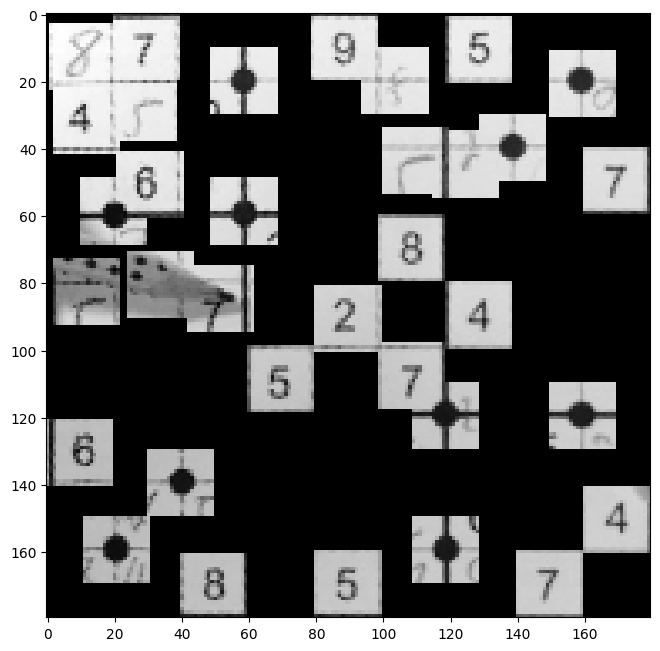

In [7]:
possible_digits=np.zeros(ROI.shape)
for i in range(h):
    for j in range(w):
        if max[i,j]:
            possible_digits[i:i+20,j:j+20]=ROI[i:i+20,j:j+20]
plt.imshow(possible_digits)
    